# Setup

## Imports

In [59]:
import pandas as pd

from hashlib import md5 as md5hash
from pandas.plotting import scatter_matrix

Scikit-Learn modules

In [107]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib

Custom Hands-On-ML modules

In [2]:
from honutils import CategoricalEncoder

Custom vai modules

In [63]:
from vaiutils import summarize_tensor, path_consts

## Define Useful Variables and Functions

In [69]:
for k, v in path_consts():
    exec(k + '=v')

In [4]:
DIR_DATA = "datasets/housing"

In [5]:
FRAC_TEST = 0.2

In [6]:
def rmse(y_true, y_pred): return np.sqrt(mean_squared_error(y_true, y_pred))

## Load Data

In [8]:
data = pd.read_csv(DIR_DATA + '/housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Glance at Data

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [10]:
data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [11]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


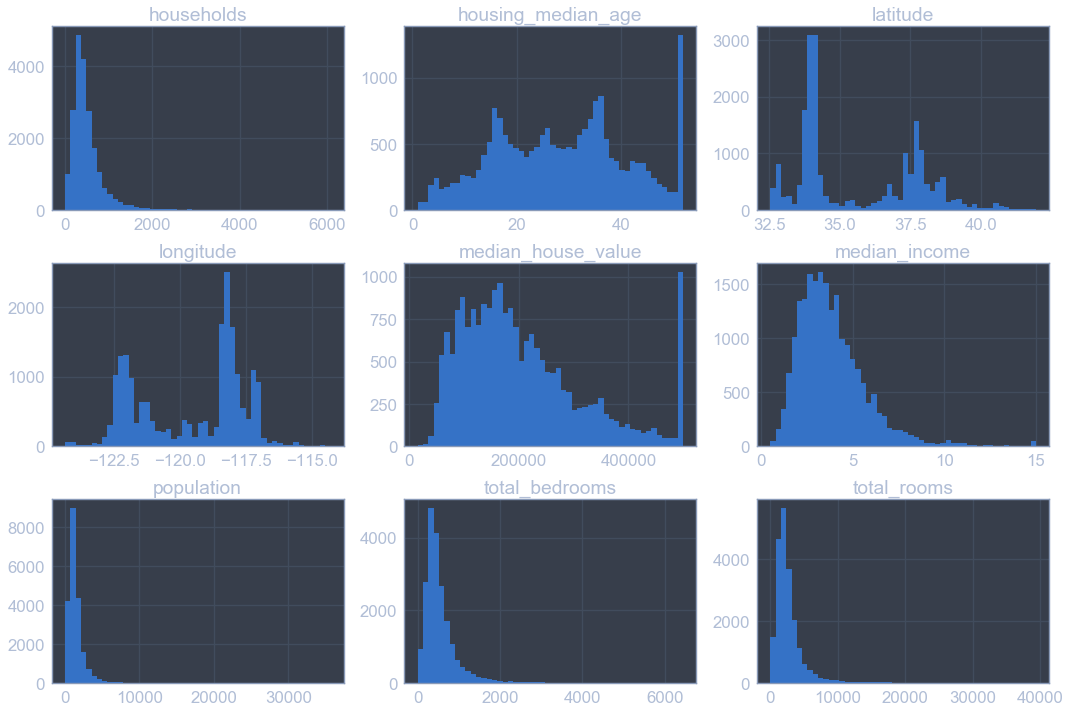

In [12]:
data.hist(bins=50)
plt.show()

## Create Test Set

Random Sampling

In [13]:
data["_id"] = data["longitude"] * 1000 + data["latitude"]
test_ids = data["_id"].apply(lambda x: md5hash(
    np.int64(x)).digest()[-1] < 256 * FRAC_TEST)

train_data, test_data = data.loc[~test_ids], data.loc[test_ids]

Stratified Sampling

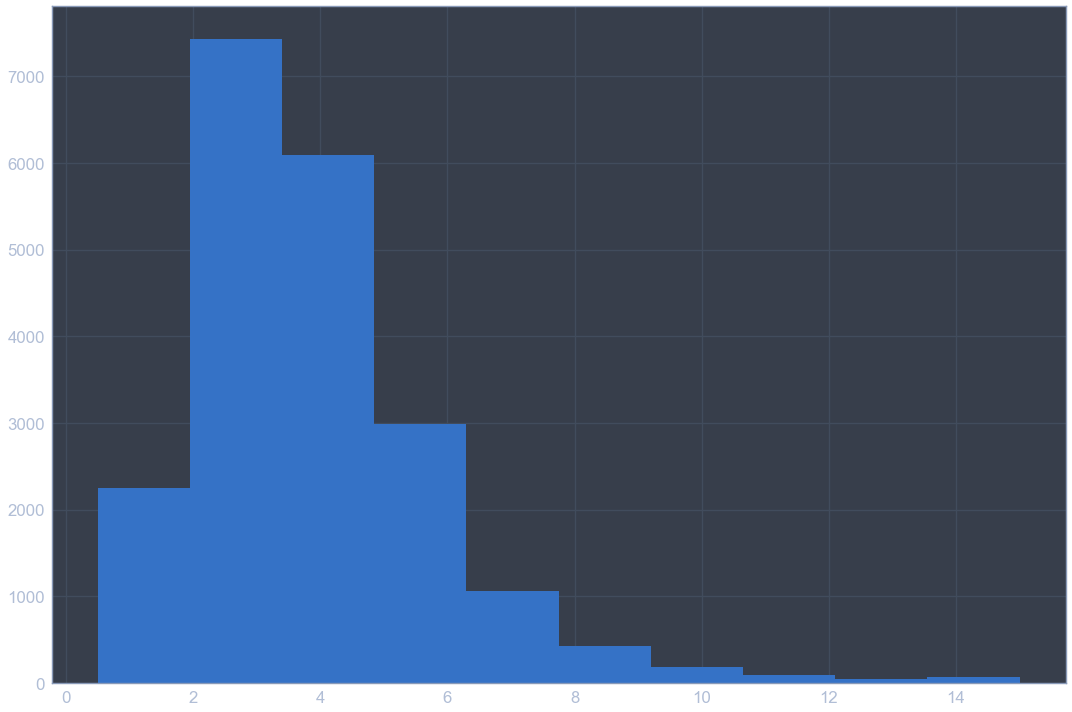

In [14]:
data["median_income"].hist()

In [15]:
data["income_cat"] = np.ceil(data["median_income"] / 1.5)
data["income_cat"].where(data["income_cat"] < 5, 5.0, inplace=True)

In [16]:
data["_id"] = data["longitude"] * 1000 + data["latitude"]
test_ids = data["_id"].apply(lambda x: md5hash(
    np.int64(x)).digest()[-1] < 256 * FRAC_TEST)

train_data, test_data = data.loc[~test_ids], data.loc[test_ids]

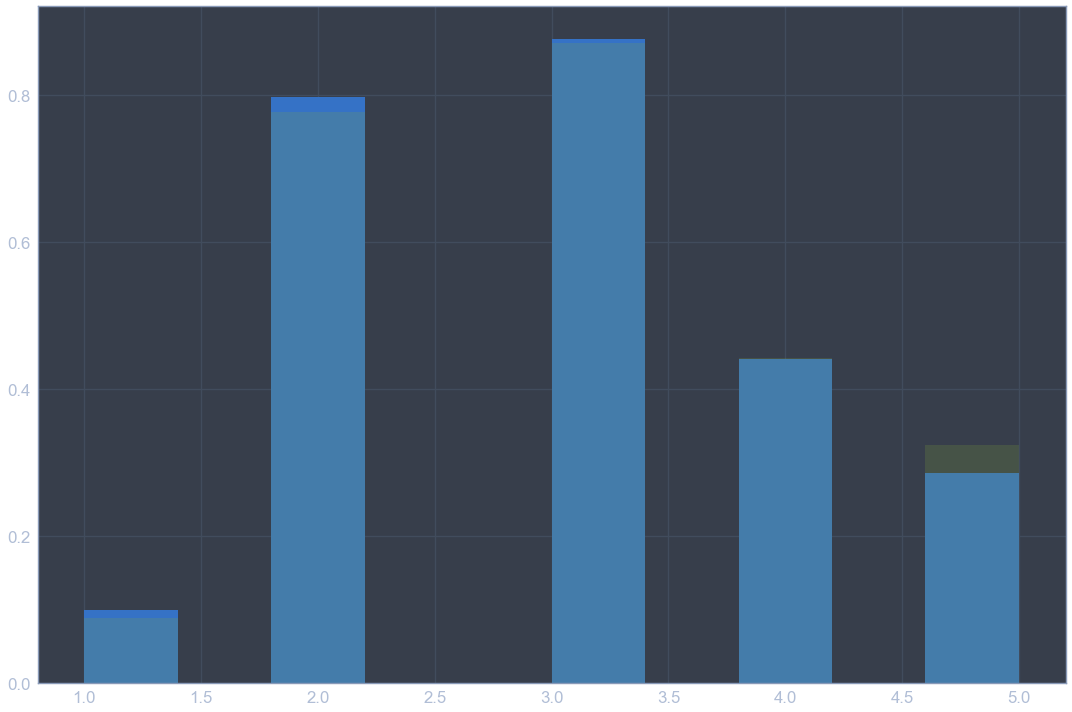

In [17]:
data["income_cat"].hist(normed=True)
test_data["income_cat"].hist(normed=True, alpha=0.2)

<Container object of 5 artists>

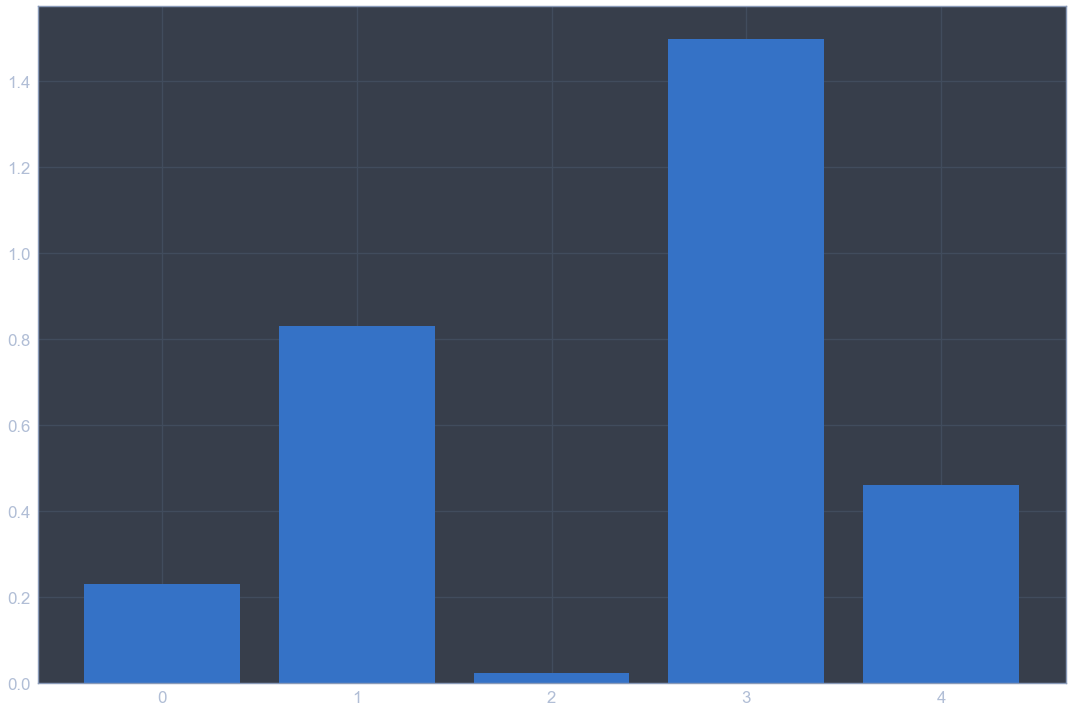

In [18]:
plt.bar(range(5), abs(data["income_cat"].value_counts(
) / len(data) - test_data["income_cat"].value_counts() / len(test_data)) * 100)

In [19]:
split = StratifiedShuffleSplit(1, FRAC_TEST, random_state=42)

In [20]:
for train_ids, test_ids in split.split(data, data["income_cat"]):
    train_data = data.loc[train_ids]
    test_data = data.loc[test_ids]

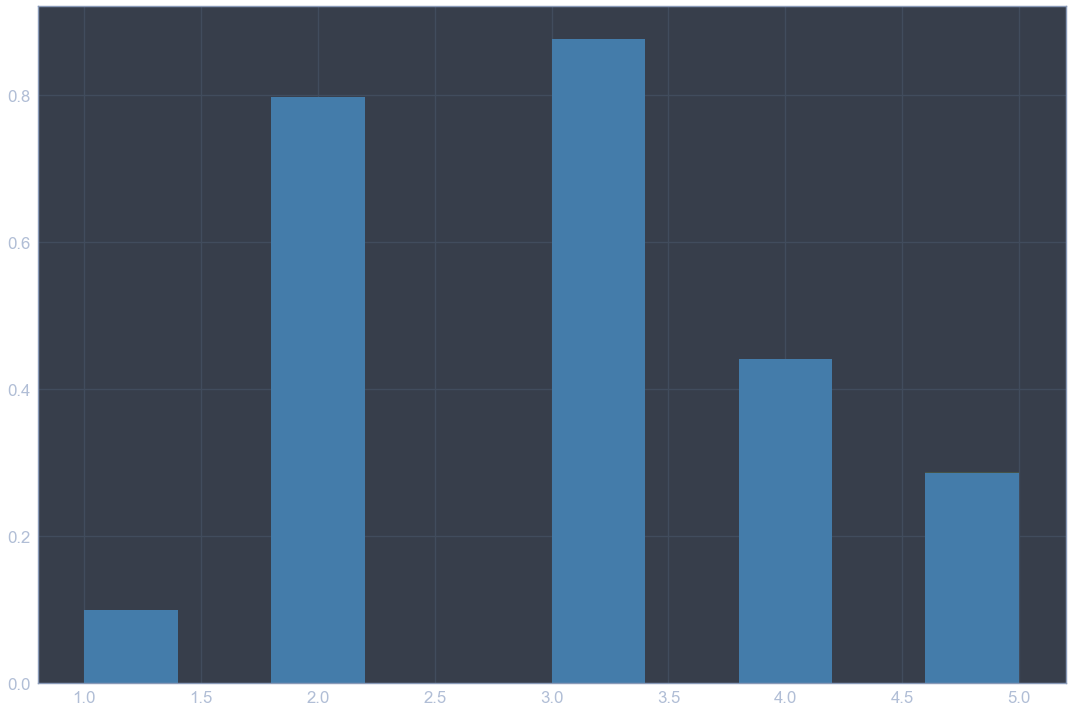

In [21]:
data["income_cat"].hist(normed=True)
test_data["income_cat"].hist(normed=True, alpha=0.2)

<Container object of 5 artists>

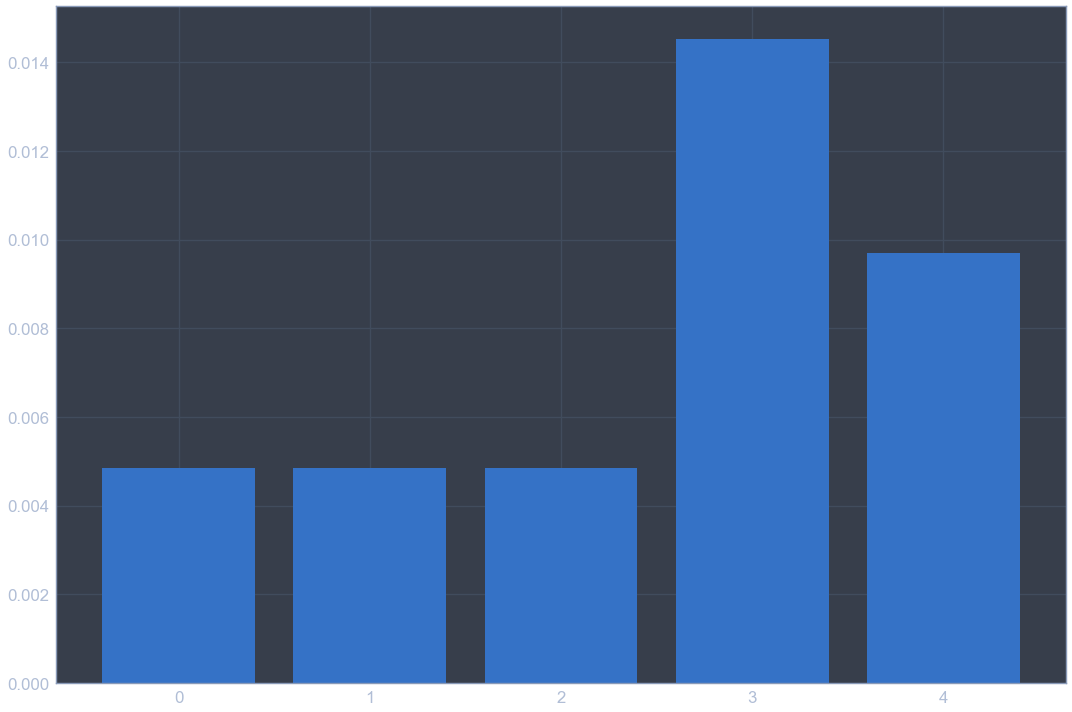

In [22]:
plt.bar(range(5), abs(data["income_cat"].value_counts(
) / len(data) - test_data["income_cat"].value_counts() / len(test_data)) * 100)

In [23]:
for d in (train_data, test_data):
    d.drop(["income_cat", "_id"], axis=1, inplace=True)
data = train_data
del train_data

# Explore Data

## GeoPlot

In [24]:
explore_data = data.copy()

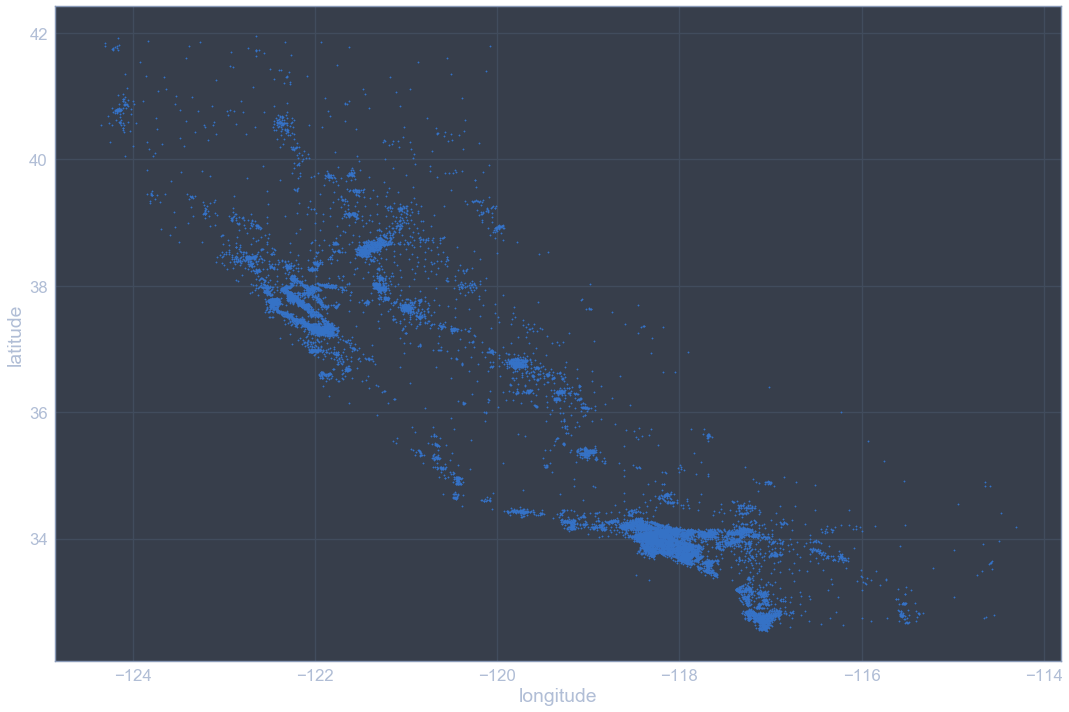

In [25]:
explore_data.plot(kind='scatter', x='longitude', y='latitude', color='b',
                  s=10, marker='.')

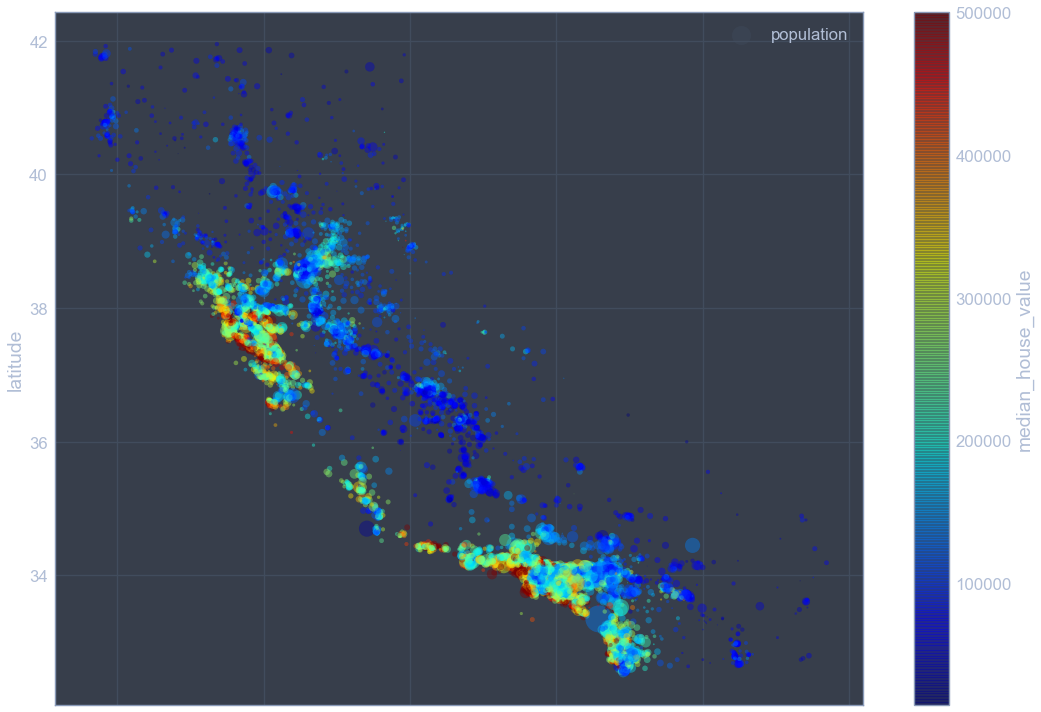

In [26]:
explore_data.plot(kind='scatter', x='longitude', y='latitude', c='median_house_value',
                  cmap='jet', label='population', s=explore_data["population"] / 50,
                  marker='o', alpha=0.4)

## Correlations

In [27]:
abs(explore_data.corr()["median_house_value"]).sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
latitude              0.142724
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
longitude             0.047432
population            0.026920
Name: median_house_value, dtype: float64

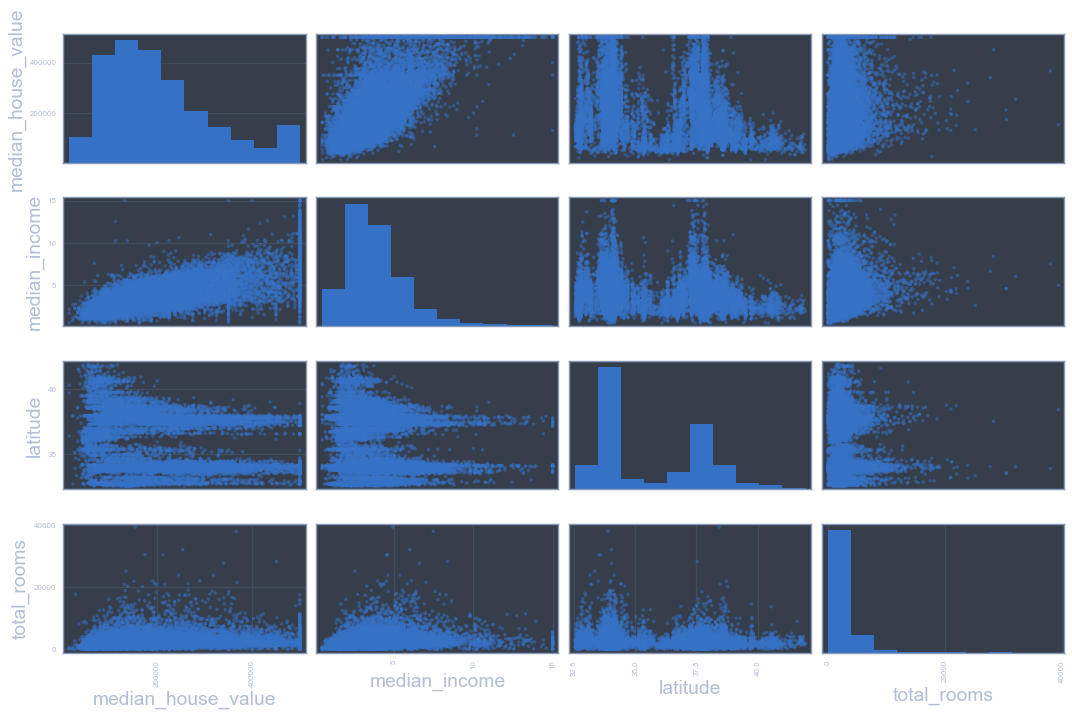

In [28]:
scattributes = ["median_house_value",
                "median_income", "latitude", "total_rooms"]
scatter_matrix(explore_data[scattributes])
plt.show()

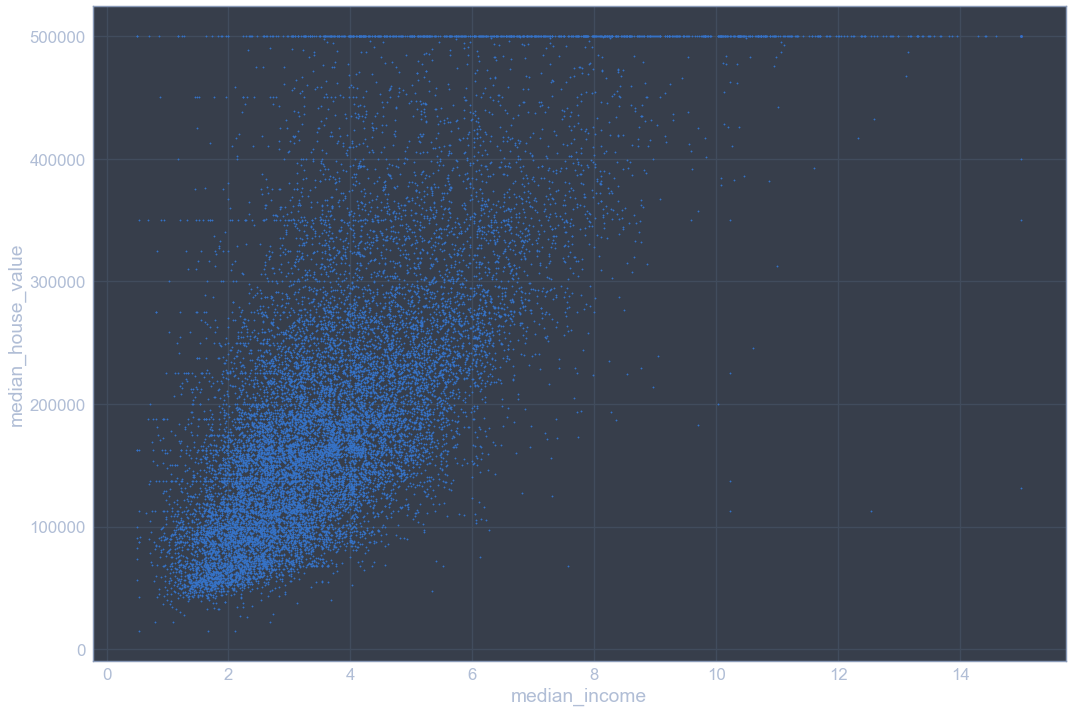

In [29]:
explore_data.plot(kind='scatter', x='median_income', y='median_house_value', color='b',
                  s=10, marker='.')

## Attribute Combinations

In [30]:
explore_data["rooms_per_household"] = explore_data["total_rooms"] / \
    explore_data["households"]
explore_data["bedrooms_per_room"] = explore_data["total_bedrooms"] / \
    explore_data["total_rooms"]
explore_data["population_per_household"] = explore_data["population"] / \
    explore_data["households"]

In [31]:
abs(explore_data.corr()["median_house_value"]).sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
bedrooms_per_room           0.259984
rooms_per_household         0.146285
latitude                    0.142724
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
longitude                   0.047432
population                  0.026920
population_per_household    0.021985
Name: median_house_value, dtype: float64

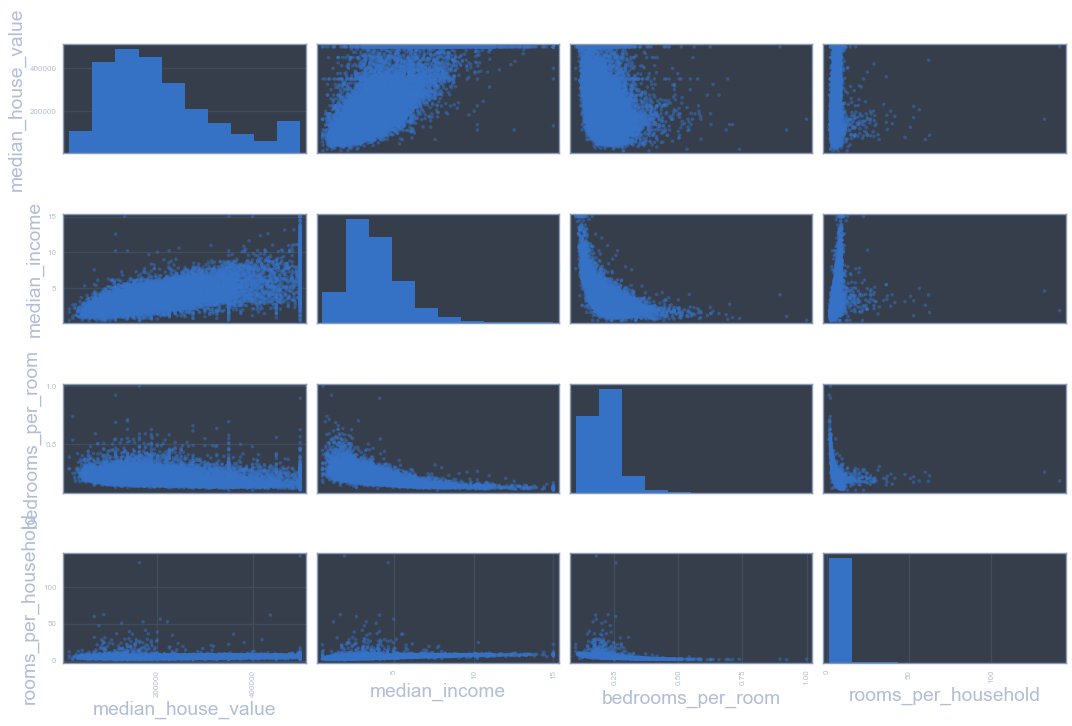

In [32]:
scattributes = ["median_house_value", "median_income",
                "bedrooms_per_room", "rooms_per_household"]
scatter_matrix(explore_data[scattributes])
plt.show()

In [33]:
del explore_data

# Prepare Data

## Separate the Labels from the Data

In [34]:
labels = data["median_house_value"].copy()
data.drop("median_house_value", axis=1, inplace=True)

## Clean Data

In [35]:
def drop_nan(dataset, attributes=None, strategy='median'):
    if strategy == 'drop':
        dataset.dropna(subset=attributes, inplace=True)
    elif strategy == 'remove':
        dataset.drop(attributes, axis=1, inplace=True)
    elif strategy == 'median':
        median = dataset[attributes].median()
        dataset[attributes].fillna(median)
    else:
        raise ValueError(
            "Attribute 'strategy' must be one of 'drop', 'remove' or 'median'")

In [36]:
imputer = Imputer(strategy='median')

In [37]:
data_categorical = data["ocean_proximity"]
data.drop("ocean_proximity", axis=1, inplace=True)

In [38]:
imputer.fit(data)
data = pd.DataFrame(imputer.transform(data), columns=data.columns)

In [39]:
data = data.assign(ocean_proximity=data_categorical.values)

## Categorical Attribute

In [40]:
categoricalencoder = CategoricalEncoder(encoding='onehot-dense')

In [41]:
categoricalencoder.fit_transform(data_categorical.values.reshape(-1, 1))

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

## Custom Transformations

In [42]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.__indices = {'rooms': 3, 'bedrooms': 4,
                          'population': 5, 'household': 6}
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        rooms_per_household = X[:, self.__indices['rooms']
                                ] / X[:, self.__indices['household']]
        population_per_household = X[:, self.__indices['population']
                                     ] / X[:, self.__indices['household']]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, self.__indices['bedrooms']
                                  ] / X[:, self.__indices['rooms']]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        return np.c_[X, rooms_per_household, population_per_household]

In [43]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.attributes].values

## Transformation Pipelines

In [44]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(list(data)[:-1])),
    ('imputer', Imputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

In [45]:
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(["ocean_proximity"])),
    ('cat_encoder', CategoricalEncoder(encoding='onehot-dense'))
])

In [46]:
full_pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

## Put it all Together

In [47]:
X = full_pipeline.fit_transform(data)

# Select and Train Model

## Training

### Linear Model

In [48]:
lin_reg = LinearRegression()
lin_reg.fit(X, labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [49]:
lin_reg.coef_, lin_reg.intercept_

(array([ -55650.4116403 ,  -56716.45236929,   13732.83841856,
          -1933.1277138 ,    7330.04062103,  -45708.26306673,
          45455.47519691,   74714.39134154,    6605.12802802,
           1042.95709453,    9249.75886697,  -18016.52432168,
         -55219.15208555,  110357.78363967,  -22479.84008184,
         -14642.2671506 ]), 236914.99732815975)

In [50]:
print("Predictions:\t", lin_reg.predict(X[:5]).astype('int'))
print("Actual:\t\t", np.array(list(labels[:5])).astype('int'))
print("RMSE: ${:,.0f}".format(rmse(lin_reg.predict(X), labels)))

Predictions:	 [210644 317768 210956  59218 189747]
Actual:		 [286600 340600 196900  46300 254500]
RMSE: $68,628


### Decision Tree

In [51]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X, labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [52]:
print("RMSE: ${:,.0f}".format(rmse(tree_reg.predict(X), labels)))

RMSE: $0


### Random Forest

In [60]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X, labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [61]:
print("RMSE: ${:,.0f}".format(rmse(forest_reg.predict(X), labels)))

RMSE: $22,548


### Support Vector Machine

In [116]:
sv_reg = SVR('linear')
sv_reg.fit(X, labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [117]:
print("RMSE: ${:,.0f}".format(rmse(forest_reg.predict(X), labels)))

RMSE: $22,548


## Cross Validation

In [56]:
def score_model_cv(model, name=''):
    scores = cross_val_score(model, X, labels,
                             scoring='neg_mean_squared_error', cv=10)
    rmse_scores = np.sqrt(-scores)
    summarize_tensor(rmse_scores, name, rugs=True)

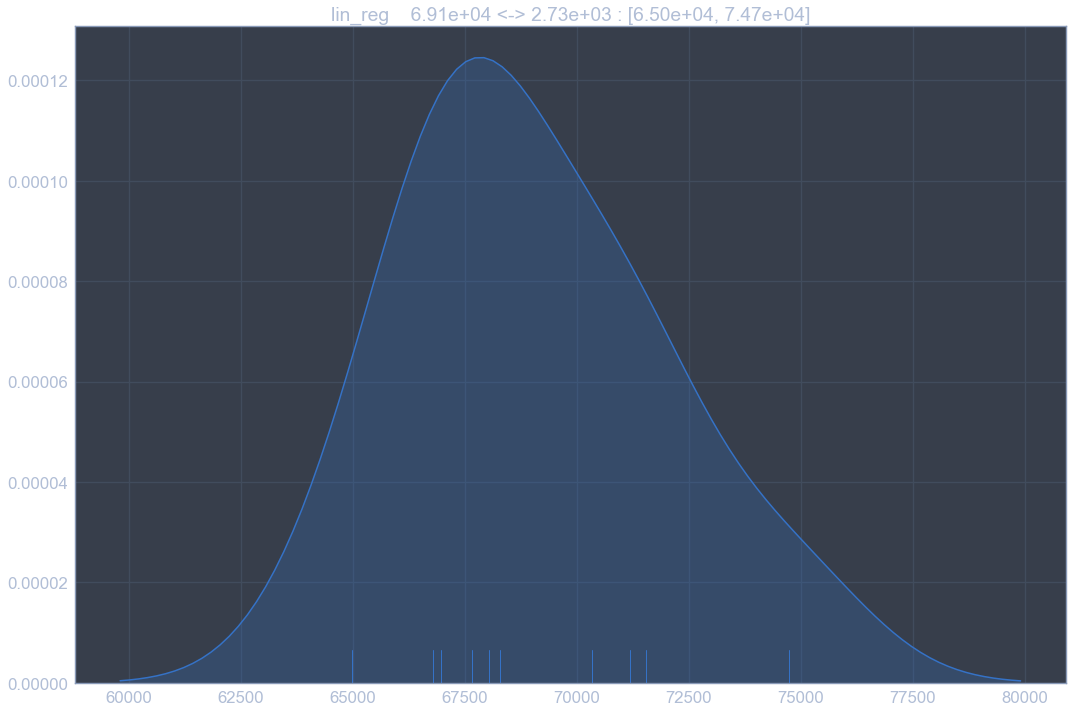

In [57]:
score_model_cv(lin_reg, 'lin_reg')

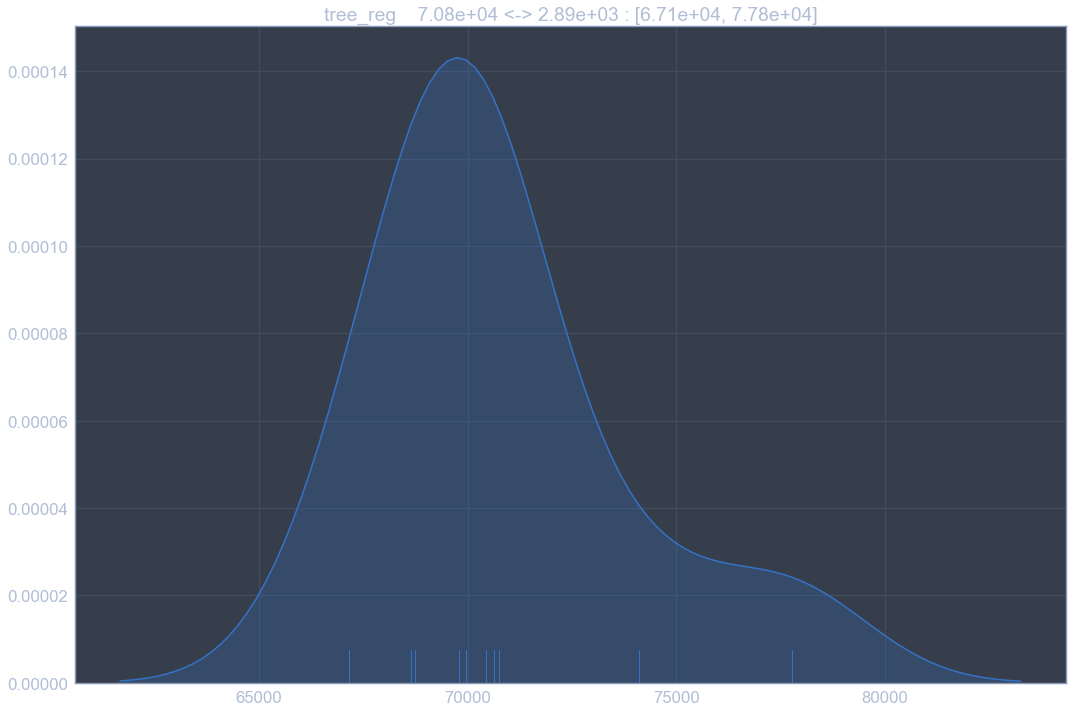

In [58]:
score_model_cv(tree_reg, 'tree_reg')

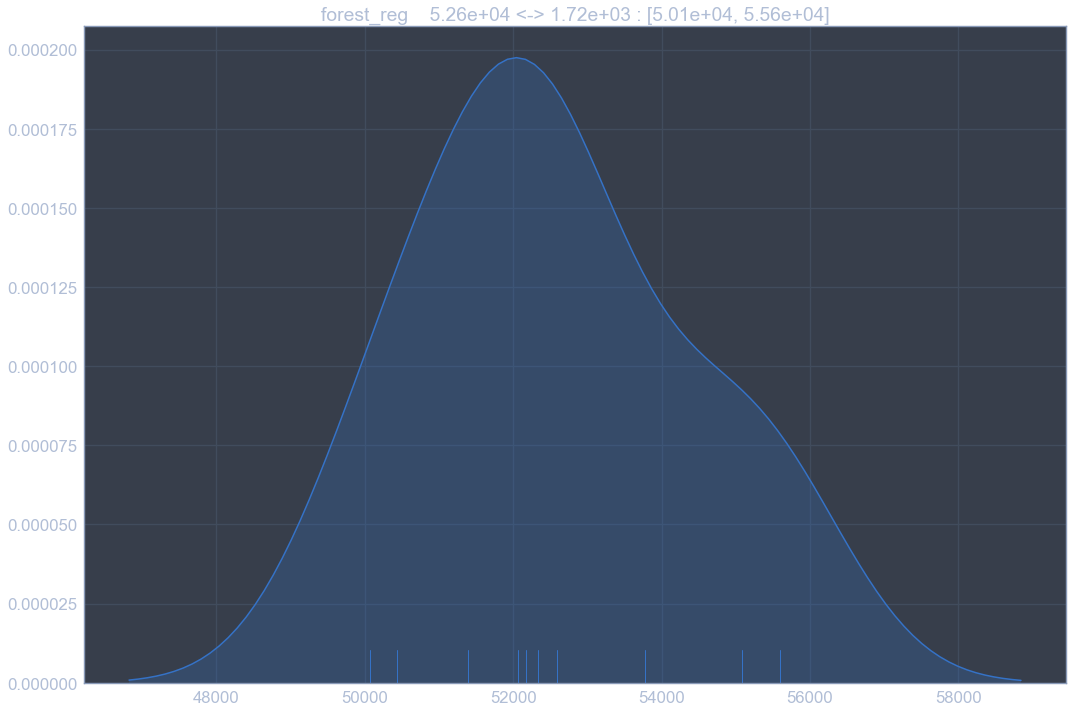

In [62]:
score_model_cv(forest_reg, 'forest_reg')

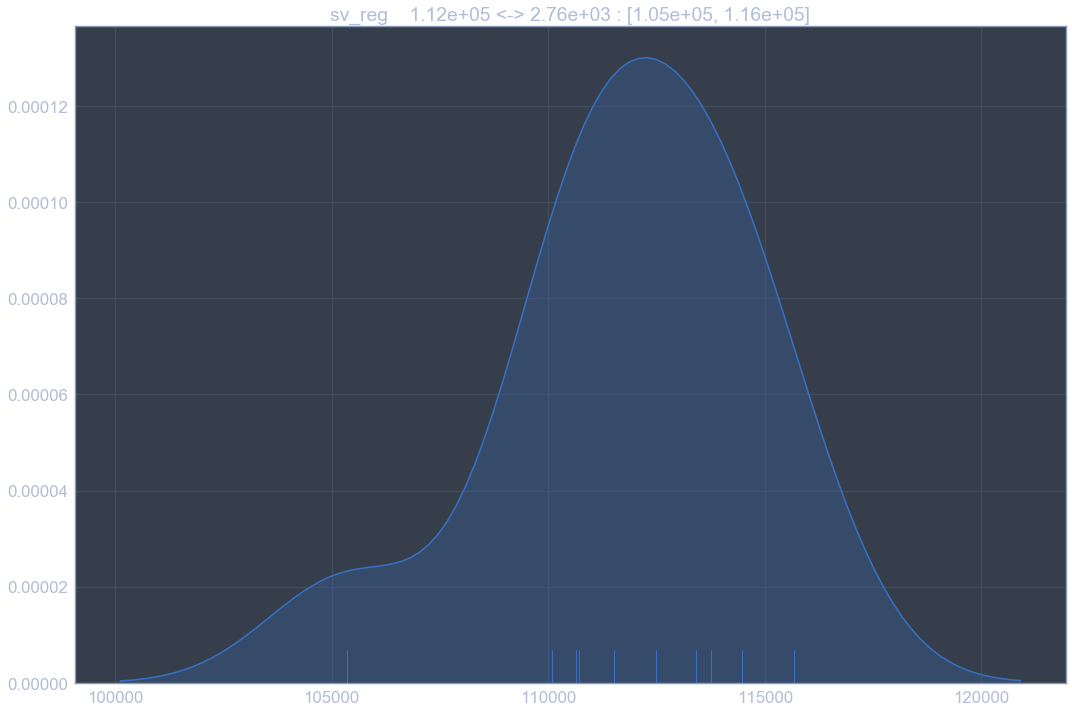

In [118]:
score_model_cv(sv_reg, 'sv_reg')

## Save models

In [71]:
joblib.dump(lin_reg, 'lin_reg.p')
joblib.dump(tree_reg, 'tree_reg.p')
joblib.dump(forest_reg, 'forest_reg.p')
joblib.dump(sv_reg, 'sv_reg.p')

['forest_reg.p']

# Fine-Tune Model

## Grid Search

In [73]:
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}]

In [74]:
grid_search = GridSearchCV(RandomForestRegressor(), param_grid,
                           'neg_mean_squared_error', cv=5)
grid_search.fit(X, labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [76]:
grid_search.best_params_, grid_search.best_estimator_

({'max_features': 6, 'n_estimators': 30},
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=False))

In [91]:
cv_res = grid_search.cv_results_
cv_order = np.argsort(cv_res["mean_test_score"])[::-1]

for mean_score, params in zip(cv_res['mean_test_score'][cv_order],
                              np.array(cv_res["params"])[cv_order]):
    print("${:,.0f}\t{}".format(np.sqrt(-mean_score), params))

$49,839	{'max_features': 6, 'n_estimators': 30}
$50,348	{'max_features': 8, 'n_estimators': 30}
$50,516	{'max_features': 4, 'n_estimators': 30}
$51,650	{'bootstrap': False, 'max_features': 4, 'n_estimators': 10}
$52,124	{'max_features': 8, 'n_estimators': 10}
$52,425	{'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
$52,659	{'max_features': 6, 'n_estimators': 10}
$52,721	{'max_features': 4, 'n_estimators': 10}
$52,909	{'max_features': 2, 'n_estimators': 30}
$54,587	{'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
$55,173	{'max_features': 2, 'n_estimators': 10}
$58,506	{'max_features': 8, 'n_estimators': 3}
$58,869	{'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
$59,443	{'max_features': 6, 'n_estimators': 3}
$60,734	{'max_features': 4, 'n_estimators': 3}
$60,801	{'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
$61,681	{'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
$63,709	{'max_features': 2, 'n_estimators': 3}


## Analyze Model

In [102]:
attribs = list(data) + ["rooms_per_hhold", "pop_per_hhold",
                        "bedrooms_per_room"] + list(data_categorical.factorize()[1])

In [103]:
sorted(zip(grid_search.best_estimator_.feature_importances_,
           attribs), reverse=True)

[(0.32883354793292058, 'median_income'),
 (0.14841243293566683, '<1H OCEAN'),
 (0.10564104391419983, 'rooms_per_hhold'),
 (0.073975229709977261, 'longitude'),
 (0.070635744372552073, 'latitude'),
 (0.068997703253906487, 'pop_per_hhold'),
 (0.067931442763698627, 'ocean_proximity'),
 (0.041182341047259444, 'housing_median_age'),
 (0.018401474371061589, 'population'),
 (0.017027557251341845, 'bedrooms_per_room'),
 (0.016934555966369714, 'total_bedrooms'),
 (0.016900484260061428, 'total_rooms'),
 (0.016095570088879817, 'households'),
 (0.0044651516085719954, 'NEAR BAY'),
 (0.0044349077732745859, 'INLAND'),
 (0.00013081275025797102, 'NEAR OCEAN')]

## Evaluate Model

In [106]:
X_test = full_pipeline.transform(test_data.drop("median_house_value", axis=1))
y_test = test_data["median_house_value"]

print("Final RMSE: ${:,.0f}".format(rmse(y_test,
                                        grid_search.best_estimator_.predict(X_test))))

Final RMSE: $47,799
